# TME 1 - Arbres de décision, sélection de modèles

### L'essentiel sur les arbres de décision

In [1]:
import numpy as np

def entropie(vect):
	_, counts = np.unique(vect, return_counts=True)
	py = np.array(counts / len(vect))
	return -np.sum(py * np.log(py))

def entropie_cond(list_vect):
	p = 0
	h = 0
	for vec in list_vect:
		p += len(vec) * entropie(vec)
		h += len(vec)
	return p/h

def get_entro(x,y,fields):
	entro = []
	entro_cond = []
	for i in range(x.shape[1]):
		# entropie de la categorie
		entro.append(entropie(y))
		# entropie de la categorie conditionnellement a toute les autres
		entro_cond.append(entropie_cond([y[(x[:, i]==1)], y[(x[:, i]!=1)]]))
		print("-----------------------------")
		print("categorie :", fields[i])
		print("--> entropie =", entro[i])
		print("--> entropie conditonnelle =", entro_cond[i])
		print('--> difference entropie = ', entro_cond[i] - entro[i])
	entro = np.array(entro)
	entro_cond = np.array(entro_cond)
	diff = entro - entro_cond
	max_index = diff.argmax()
	print("La meilleure diff d'entropie est la categorie : ", fields[max_index] ," avec un score de : ", diff[max_index])
	return entro, entro_cond

In [2]:
import pickle

# data : tableau(films, features), id2titles : dictionnaire id -> titre,
# fields : id feature -> nom
[data, id2titles, fields] = pickle.load(open("data/imdb_extrait.pkl","rb"))
# la derniere colonne est le vote
datax = data[:,:32]
datay = np.array([1 if x[33] > 6.5 else -1 for x in data])

print(data.shape)
print(len(id2titles))
print(len(fields))

(4587, 34)
4587
34


In [3]:
listeE, listeEC = get_entro(datax,datay,fields)

-----------------------------
categorie : Sci-Fi
--> entropie = 0.6840731540145955
--> entropie conditonnelle = 0.6799402806092876
--> difference entropie =  -0.00413287340530788
-----------------------------
categorie : Crime
--> entropie = 0.6840731540145955
--> entropie conditonnelle = 0.6836092907830238
--> difference entropie =  -0.00046386323157165954
-----------------------------
categorie : Romance
--> entropie = 0.6840731540145955
--> entropie conditonnelle = 0.6840711988780971
--> difference entropie =  -1.9551364983660946e-06
-----------------------------
categorie : Animation
--> entropie = 0.6840731540145955
--> entropie conditonnelle = 0.6825230243876741
--> difference entropie =  -0.0015501296269213594
-----------------------------
categorie : Music
--> entropie = 0.6840731540145955
--> entropie conditonnelle = 0.6840615675797059
--> difference entropie =  -1.1586434889521158e-05
-----------------------------
categorie : Comedy
--> entropie = 0.6840731540145955
--> entro

### Quelques expériences préliminaires

In [4]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree
import pydotplus
id2genre = [x[1] for x in sorted(fields.items())[:-2]]

dt = DTree()
dt.max_depth = 3 # on fixe la taille max de l’arbre a 3
dt.min_samples_split = 2 # nombre minimum d’exemples pour spliter un noeud
dt.fit(datax, datay)
dt.predict(datax[:5,:])
print(dt.score(datax, datay))
# utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/GraphvizOnline
export_graphviz(dt, out_file ="tree3.dot", feature_names = id2genre)
# ou avec pydotplus
tdot = export_graphviz(dt, feature_names = id2genre)
pydotplus.graph_from_dot_data(tdot).write_pdf("tree3.pdf")

dt = DTree()
dt.max_depth = 5 # on fixe la taille max de l’arbre a 5
dt.min_samples_split = 2 # nombre minimum d’exemples pour spliter un noeud
dt.fit(datax, datay)
dt.predict(datax[:5,:])
print(dt.score(datax, datay))
# utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/GraphvizOnline
export_graphviz(dt, out_file ="tree5.dot", feature_names = id2genre)
# ou avec pydotplus
tdot = export_graphviz(dt, feature_names = id2genre)
pydotplus.graph_from_dot_data(tdot).write_pdf("tree5.pdf")

dt = DTree()
dt.max_depth = 10 # on fixe la taille max de l’arbre a 10
dt.min_samples_split = 2 # nombre minimum d’exemples pour spliter un noeud
dt.fit(datax, datay)
dt.predict(datax[:5,:])
print(dt.score(datax, datay))
# utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/GraphvizOnline
export_graphviz(dt, out_file ="tree10.dot", feature_names = id2genre)
# ou avec pydotplus
tdot = export_graphviz(dt, feature_names = id2genre)
pydotplus.graph_from_dot_data(tdot).write_pdf("tree10.pdf")

0.7183344233703945
0.736647045999564
0.8489208633093526


True

Le nombre d'exemple diminue lorsque l'on parcours la profondeur de l'arbre. C'est normal car on cherche de plus en plus de moyen de discriminer les exemples.

Plus on ajoute de la profondeur, plus le score de classificaton augmente. C'est normal car lorsque la profondeur tend vers la profondeur maximum, on tend vers un overfit du modele

Ce n'est pas un indicateur fiable si on veut un score de précision. Il faudrait peut être normaliser le score grâce a le parametre de profondeur max. Sinon on peut tester notre score sur des données de validation

### Sur et sous apprentissage

In [5]:
import matplotlib.pyplot as plt

def split_data(x, y, ratio):
	limit = int(ratio*len(x))
	return x[:limit], y[:limit], x[limit:], y[limit:]

def plot_acc(max_depth, datax_train, datay_train, datax_test, datay_test, k):
	acc_train = []
	acc_test = []
	for i in range(max_depth):
		dt = DTree()
		dt.max_depth = i+1
		dt.min_samples_split = 2
		dt.fit(datax_train, datay_train)
		dt.predict(datax_train[:5,:])
		acc_train.append(dt.score(datax_train, datay_train))
		acc_test.append(dt.score(datax_test, datay_test))
	plt.xlabel("depth")
	plt.ylabel("acc")
	plt.plot(acc_train, label="train")
	plt.plot(acc_test, label="test")
	plt.title(str("Split train : " + str(k)))
	plt.legend()
	plt.show()
	
	
def multiple_plot_acc(max_depth, datax_train, datay_train, datax_test, datay_test, k):
	plt.figure(figsize=(8, 8), dpi=80)
	acc_train_tot = []
	acc_test_tot = []
	for elt in k:
		datax_train, datay_train, datax_test, datay_test = split_data(datax, datay, elt)
		acc_train = []
		acc_test = []
		for i in range(max_depth):
			dt = DTree()
			dt.max_depth = i+1
			dt.min_samples_split = 2
			dt.fit(datax_train, datay_train)
			dt.predict(datax_train[:5,:])
			acc_train.append(dt.score(datax_train, datay_train))
			acc_test.append(dt.score(datax_test, datay_test))
		acc_train_tot.append(acc_train)
		acc_test_tot.append(acc_test)
	plt.xlabel("depth")
	plt.ylabel("acc")
	for i in range(len(acc_train_tot)):
		plt.plot(acc_train_tot[i], label=str("train"+str(k[i])))
		plt.plot(acc_test_tot[i], label=str("test"+str(k[i])))
	plt.title("Multiple plot")
	plt.legend()
	plt.show()

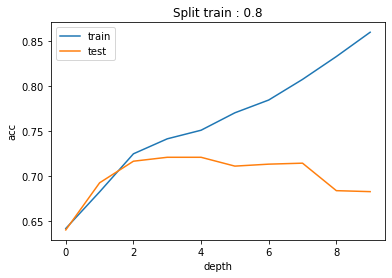

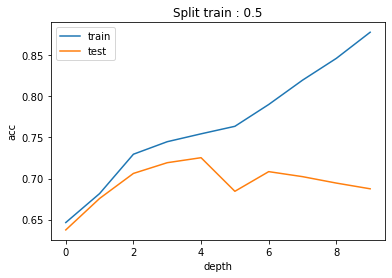

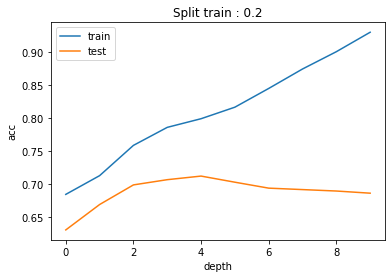

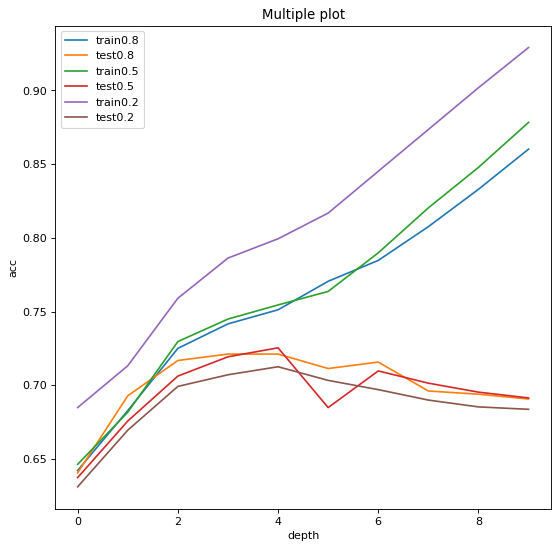

In [6]:
max_depth = 10
for k in [0.8, 0.5, 0.2]:
	datax_train, datay_train, datax_test, datay_test = split_data(datax, datay, k)
	plot_acc(max_depth, datax_train, datay_train, datax_test, datay_test, k)
multiple_plot_acc(max_depth, datax_train, datay_train, datax_test, datay_test, k=[0.8, 0.5, 0.2])

Quand il y a peu de d'exemple d'apprentissage : l'accuracy train tend vers 1 rapidement et l'overfit est fort et l'accuracy test est a 0.7. Quand il y a beaucoup d'exemple d'apprentissage : l'accuracy train tend moins rapidement vers 1 mais mais l'overfit est moins fort et l'accuracy test est un peu plus elevé (0.72). Le comportemenet est cependant semblable, les differentes courbes montrent un overfit.

Les resultats semblent correct mais on perd beaucoup de data pour le train à cause du split. On peut les ameliorer avec une validation croisee

### Validation croisée : sélection de modèle

Step : 0
Validation chunk index :  0 458


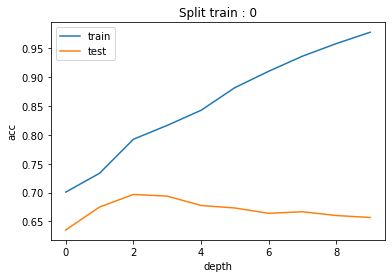

Step : 1
Validation chunk index :  458 916


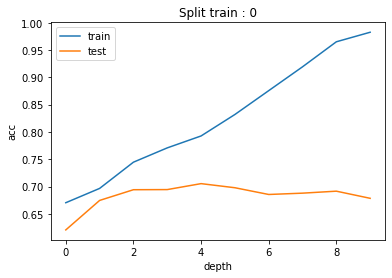

Step : 2
Validation chunk index :  916 1374


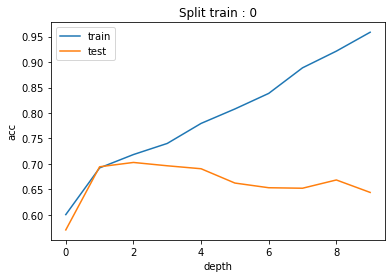

Step : 3
Validation chunk index :  1374 1832


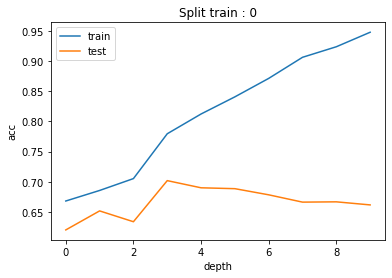

Step : 4
Validation chunk index :  1832 2290


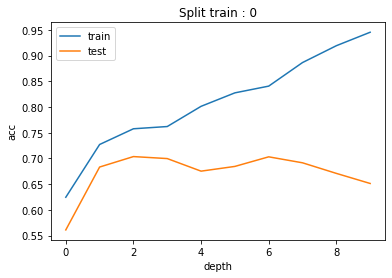

Step : 5
Validation chunk index :  2290 2748


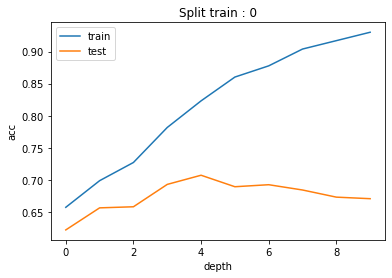

Step : 6
Validation chunk index :  2748 3206


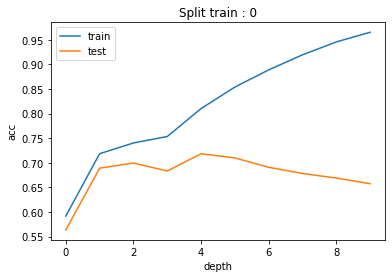

Step : 7
Validation chunk index :  3206 3664


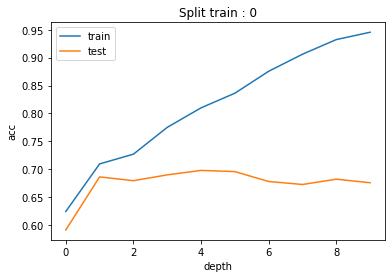

Step : 8
Validation chunk index :  3664 4122


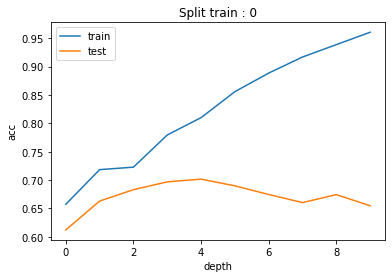

Step : 9
Validation chunk index :  4122 4580


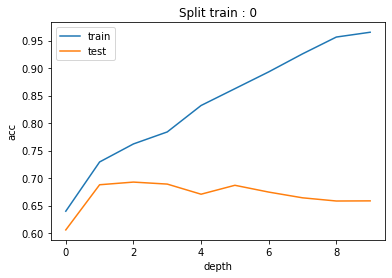

In [7]:
def crossvalid_split(x, y, n_chunk):
	n = x.shape[0]
	interval = n//n_chunk
	for i in range(n_chunk):
		print("Step :", i)
		
		limit = i*interval
		limit2 = (i+1)*interval
		
		print("Validation chunk index : ", limit, limit2)
		
		chunk_x = x[limit:limit2]
		chunk_y = y[limit:limit2]
		
		if i == 0:
			rest_x2 = x[limit2:]
			rest_y2 = y[limit2:]
		else:   
			rest_x2 = np.concatenate((x[0:limit], x[limit2:]), 0)
			rest_y2 = np.concatenate((y[0:limit], y[limit2:]), 0)
					
		plot_acc(10, chunk_x, chunk_y, rest_x2, rest_y2, 0)

crossvalid_split(datax, datay, 10)

# TME 2 - Estimation de densité

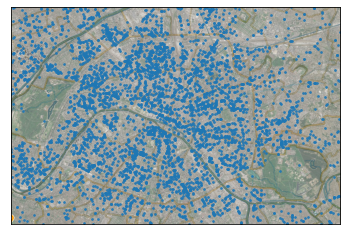

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

POI_FILENAME = "data/poi-paris.pkl"
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

def get_density2D(f,data,steps=100):
	""" Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie 
	la grille estimée et la discrétisation sur chaque axe.
	"""
	xmin, xmax = data[:,0].min(), data[:,0].max()
	ymin, ymax = data[:,1].min(), data[:,1].max()
	xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
	xx, yy = np.meshgrid(xlin,ylin)
	grid = np.c_[xx.ravel(), yy.ravel()]
	res = f.predict(grid).reshape(steps, steps)
	return res, xlin, ylin

def show_density(f, data, steps=100, log=False):
	""" Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. 
    Le paramètre log permet d'afficher la log densité plutôt que la densité brute
	"""
	res, xlin, ylin = get_density2D(f, data, steps)
	xx, yy = np.meshgrid(xlin, ylin)
	plt.figure()
	show_img()
	if log:
		res = np.log(res+1e-10)
	plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
	show_img(res)
	plt.colorbar()
	plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
	""" Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
	"""
	origin = "lower" if len(img.shape) == 2 else "upper"
	alpha = 0.3 if len(img.shape) == 2 else 1.
	plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
	## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
	""" Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

	Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
	clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
	"""
	poidata = pickle.load(open(fn, "rb"))
	data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
	note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
	return data,note

plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
class Density(object):
	def fit(self,data):
		pass
	def predict(self,data):
		pass

	def score(self,data):
		eps = 10e-10
		density = self.predict(data) + eps
		return np.sum(np.log(density))

### Méthode par histogramme

In [10]:
class Histogramme(Density):
	def __init__(self,steps=10):
		Density.__init__(self)
		self.bins = steps

	def fit(self, data):
		self.hist, _ = np.histogramdd(data, bins = (self.bins, self.bins))
		self.lb = np.min(data, axis=0)	# borne inf
		ub = np.max(data, axis=0)		# borne sup
		self.step = (ub - self.lb) / self.bins
		self.lenTrain = data.shape[0]

	def predict(self, data):
		preds = np.zeros(data.shape[0])
		for i in range(data.shape[0]):
			y, x = np.array((data[i] - self.lb) / self.step, dtype=int)
			if x < 0:
				x = 0
			elif x >= self.bins:
				x = self.bins - 1
			if y < 0:
				y = 0
			elif y >= self.bins:
				y = self.bins - 1
			preds[i] = self.hist[y, x]
		return preds / self.lenTrain / np.prod(self.step)

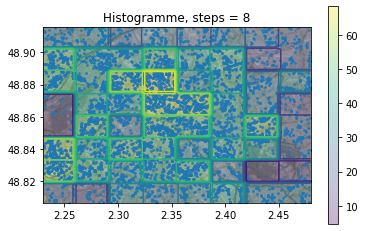

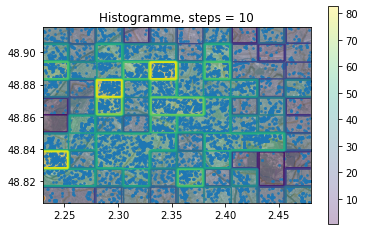

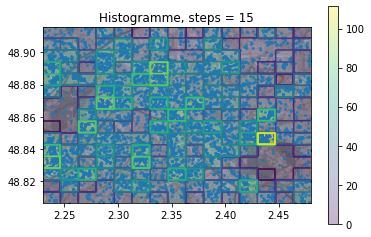

In [11]:
geo_mat, notes = load_poi("restaurant")

for steps in (8, 10, 15):
	f = Histogramme(steps)
	f.fit(geo_mat)
	show_density(f, geo_mat, steps*steps)
	plt.title(f"Histogramme, steps = {steps}")
	plt.show()

### Méthodes à noyaux

In [12]:
class KernelDensity(Density):
	def __init__(self, kernel=None, sigma=0.1):
		Density.__init__(self)
		self.kernel = kernel
		self.sigma = sigma

	def fit(self, data):
		self.data = data

	def predict(self, data):
		preds = np.zeros(data.shape[0])
		for i in range(data.shape[0]):
			preds[i] = np.sum(self.kernel((data[i] - self.data) / self.sigma))
		return preds / (self.data.shape[0] * self.sigma**self.data.shape[1])

def kernel_uniform(x):
	return np.all(np.abs(x) <= 0.5, axis=1)

def kernel_gaussian(x):
	return 2 * np.pi**(-x.shape[1] / 2) * np.exp(-0.5 * np.linalg.norm(x, axis=1)**2)

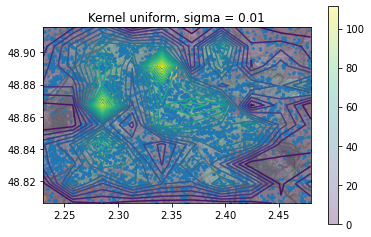

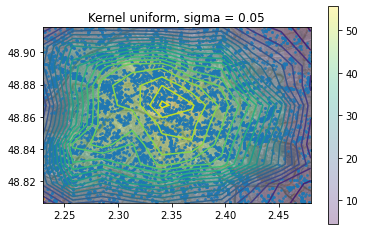

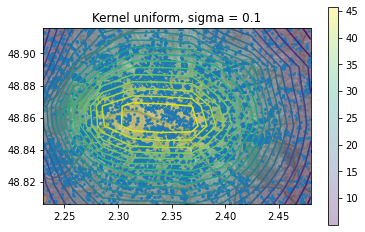

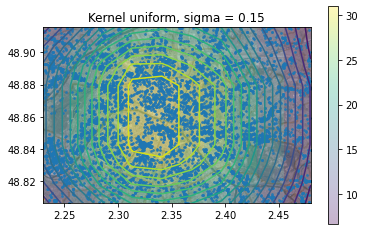

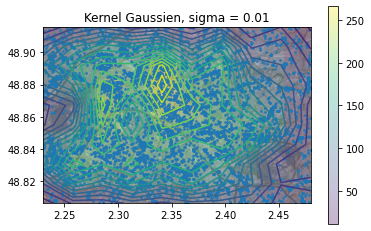

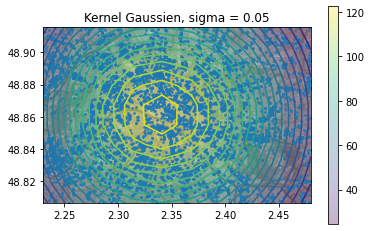

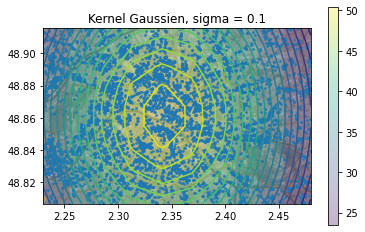

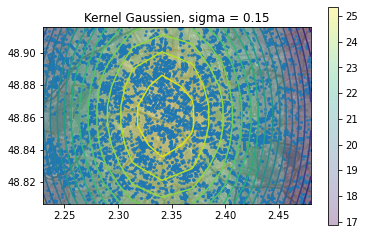

In [13]:
for sigma in (0.01, 0.05, 0.1, 0.15):
	kernel = KernelDensity(kernel_uniform, sigma)
	kernel.fit(geo_mat)
	show_density(kernel,geo_mat,steps=10)
	plt.title(f"Kernel uniform, sigma = {sigma}")
	plt.show()

for sigma in (0.01, 0.05, 0.1, 0.15):
	kernel = KernelDensity(kernel_gaussian, sigma)
	kernel.fit(geo_mat)
	show_density(kernel,geo_mat,steps=10)
	plt.title(f"Kernel Gaussien, sigma = {sigma}")
	plt.show()

### Régression par Nadaraya-Watson

In [14]:
class Nadaraya(Density):
	def __init__(self,kernel=None,sigma=0.1):
		Density.__init__(self)
		self.kernel = kernel
		self.sigma = sigma

	def fit(self, data, labels):
		self.data = data
		self.labels = labels

	def predict(self, data):
		preds = np.zeros(data.shape[0])
		for i in range(data.shape[0]):
			proj = self.kernel((data[i] - self.data) / self.sigma)
			for j in range(self.data.shape[0]):
				preds[i] += self.labels[j] * proj[j] / (np.sum(proj[j:] + 10e-4))
		return preds

In [15]:
geo_mat, notes = load_poi("night_club")

for sigma in (0.05, 0.1, 0.15):
	uni = Nadaraya(kernel_uniform, sigma=sigma)
	uni.fit(geo_mat, notes)
	preds = uni.predict(geo_mat)
	mse_uni = np.mean((preds - notes) ** 2)

	gauss = Nadaraya(kernel_gaussian, sigma=sigma)
	gauss.fit(geo_mat, notes)
	preds = gauss.predict(geo_mat)
	mse_gauss = np.mean((preds - notes) ** 2)

	print("\nsigma =", sigma)
	print(f"MSE uniform={mse_uni} gaussian={mse_gauss}")


sigma = 0.05
MSE uniform=147.01849142923527 gaussian=222.0631979621145

sigma = 0.1
MSE uniform=204.4868047924752 gaussian=221.67796192511472

sigma = 0.15
MSE uniform=212.83617694615538 gaussian=220.54423694886833


# TME 3 - Descente de gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

def mse(w,x,y):
	return (x@w - y)**2

def mse_grad(w,x,y):
	return 2 * x * (x@w - y)

def reglog(w,x,y):
	return np.log(1 + np.exp(-y * (x@w)))

def reglog_grad(w,x,y):
	return -x * y / (1 + np.exp(y * (x @ w)))

In [2]:
# Check les fonctions si elles sont bien implémentées
np.random.seed(0)
datax, datay = gen_arti(epsilon=0.1)
wrandom = np.random.randn(datax.shape[1],1)
assert(np.isclose(mse(wrandom,datax,datay).mean(),0.54731,rtol=1e-4))
assert(np.isclose(reglog(wrandom,datax,datay).mean(), 0.57053,rtol=1e-4))
assert(np.isclose(mse_grad(wrandom,datax,datay).mean(),-1.43120,rtol=1e-4))
assert(np.isclose(reglog_grad(wrandom,datax,datay).mean(),-0.42714,rtol=1e-4))
np.random.seed()

In [3]:
def grad_check(f, f_grad, N=100, eps=1e-3, d=1):
	w = np.random.rand(d, 1)
	x = np.random.rand(N, d)
	y = np.random.randint(0, 2, N).reshape(-1, 1)
	
	fx0 = f(w, x, y)
	fx = f(w+eps, x, y)
	calcul = f_grad(w, x, y)
	verite = (fx - fx0) / eps
	return np.max(np.abs(calcul - verite)) <= eps

# On check 50 fois les 2 fonctions en 1-d
for i in range(50):
	assert(grad_check(mse, mse_grad))
	assert(grad_check(reglog, reglog_grad))

### Descente de gradient

In [16]:
from tqdm import tqdm

def descente_gradient(x, y, f_loss, f_grad, eps, n_iter):
	list_w = np.zeros((n_iter, x.shape[1]))
	list_l = np.zeros(n_iter)
	w = np.random.randn(x.shape[1], 1)
	for i in tqdm(range(n_iter)):
		w = w - eps * np.mean(f_grad(w, x, y), axis=0).reshape(-1, 1)
		list_w[i,:] = w.T
		list_l[i] = np.mean(f_loss(w, x, y))
	return list_w, list_l, w

In [22]:
def analysis(lw,ll,w):
	plot_frontiere(datax,lambda x : np.sign(x.dot(w)),step=100)
	plot_data(datax,datay)
	plt.title("Classification")
	plt.show()
	
	plt.plot(ll)
	plt.title("Loss/epochs")
	plt.show()
	
	lw_w1, lw_w2 = lw[:,0], lw[:,1]
	plt.plot(lw_w1)
	plt.plot(lw_w2)
	plt.title("w1 and w2/epochs")
	plt.show()

#### Reglog + batch gradient descent

100%|██████████| 10000/10000 [00:00<00:00, 13133.57it/s]


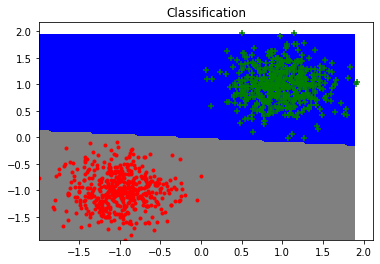

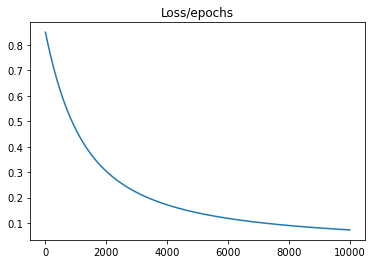

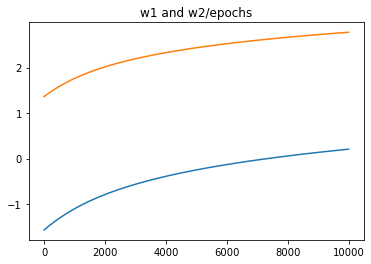

In [23]:
n_epochs = 10000
lr = 1e-3
lw, ll, w = descente_gradient(datax, datay, reglog, reglog_grad, lr, n_epochs)
analysis(lw,ll,w)

#### MSE + batch gradient descent

100%|██████████| 1000/1000 [00:00<00:00, 19701.28it/s]


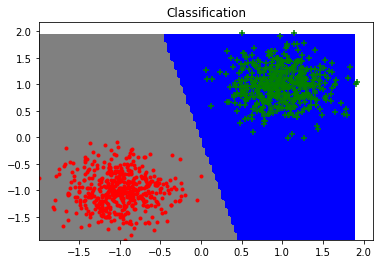

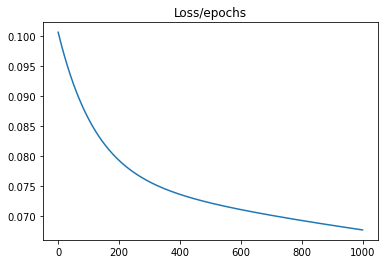

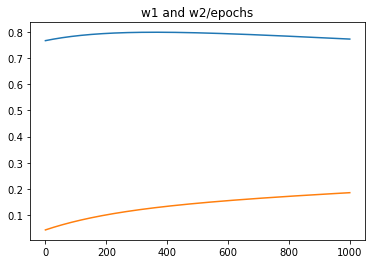

In [24]:
n_epochs = 1000
lr = 1e-3
lw, ll, w = descente_gradient(datax, datay, mse, mse_grad, lr, n_epochs)
analysis(lw,ll,w)

In [28]:
def descente_gradient_stoch(x, y, f_loss, f_grad, eps, n_iter):
	list_w = np.zeros((n_iter, x.shape[1]))
	list_l = np.zeros(n_iter)
	w = np.random.randn(x.shape[1], 1)
	n = x.shape[0]
	for i in tqdm(range(n_iter)):
		for _ in range(n):
			rand_idx = np.random.randint(n)
			w = w - eps * np.mean(f_grad(w, x[rand_idx], y[rand_idx]), axis=0).reshape(-1, 1)
		list_w[i,:] = w.T
		list_l[i] = np.mean(f_loss(w, x, y))
	return list_w, list_l, w

def descente_gradient_minibatch(x, y, f_loss, f_grad, eps, n_iter, n_batch=20):
	list_w = np.zeros((n_iter, x.shape[1]))
	list_l = np.zeros(n_iter)
	w = np.random.randn(x.shape[1], 1)
	n = x.shape[0]
	batch_size = n // n_batch
	for i in tqdm(range(n_iter)):
		for _ in range(n_batch):
			rand_idx = np.random.randint(1, n_batch - 1)
			idx_first = rand_idx * batch_size
			idx_last = rand_idx * (batch_size + 1)
			w = w - eps * np.mean(f_grad(w, x[idx_first:idx_last], y[idx_first:idx_last]), axis=0).reshape(-1, 1)
		list_w[i,:] = w.T
		list_l[i] = np.mean(f_loss(w, x, y))
	return list_w, list_l, w

100%|██████████| 100/100 [00:01<00:00, 62.86it/s]


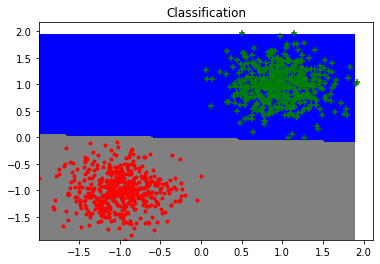

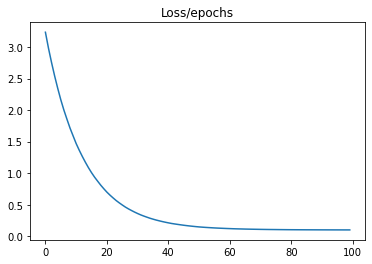

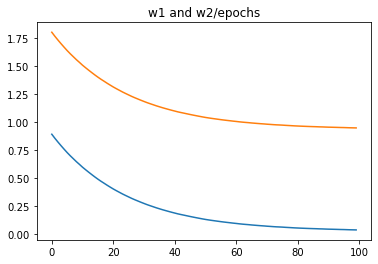

In [27]:
n_epochs = 100
lr = 1e-5	# Since we use stochastic gradient descent we need to lower the learning rate to avoid divergence
lw, ll, w = descente_gradient_stoch(datax, datay, mse, mse_grad, lr, n_epochs)
analysis(lw,ll,w)

#### MSE + minibatch gradient descent

100%|██████████| 100/100 [00:00<00:00, 2540.91it/s]


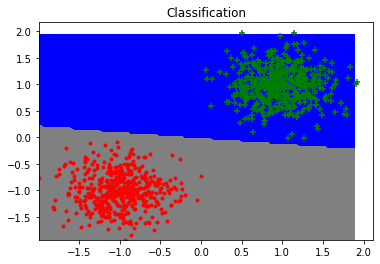

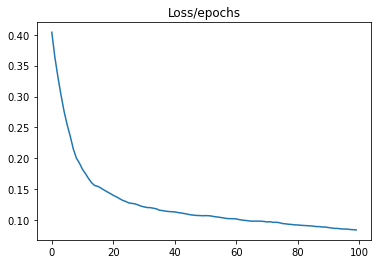

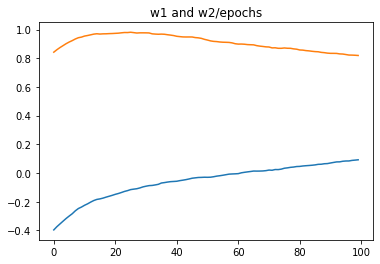

In [30]:
n_epochs = 100
learning_rate = 1e-3
lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, learning_rate, n_epochs)
analysis(lw,ll,w)

### Tester les differents Learning Rate

In [34]:
def lr_analysis(lw_tab, ll_tab, w_tab, lrs):
	lw_tab = np.array(lw_tab)
	ll_tab = np.array(ll_tab)
	w_tab = np.array(w_tab)
	lw_tab = lw_tab.reshape(lw_tab.shape[0], lw_tab.shape[1], lw_tab.shape[2])
	w_tab = w_tab.reshape(w_tab.shape[0], w_tab.shape[1])
	
	for i in range(w_tab.shape[0]):
		plot_frontiere(datax,lambda x : np.sign(x.dot(w_tab[i])),step=100)
		plot_data(datax,datay)
		plt.title("Classification with lr ="+str(lrs[i]))
		plt.show()
	
	lw_w1, lw_w2 = lw_tab[:,:,0], lw_tab[:,:,1]
	plt.figure(figsize=(8, 8))
	plt.plot(lw_w1.T)
	plt.legend(lrs)
	plt.title("w1/epochs")
	plt.show()

	plt.figure(figsize=(8, 8))
	plt.plot(lw_w2.T)
	plt.legend(lrs)
	plt.title("w2/epochs")
	plt.show()
	
	plt.figure(figsize=(8, 8))
	plt.plot(ll_tab.T)
	plt.legend(lrs)
	plt.title("loss/epochs")
	plt.show()

def plot_parametres( allw, X, y, ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    plt.figure()
    plt.contour(w1, w2, cost)
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return

In [32]:
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)

100%|██████████| 1000/1000 [00:00<00:00, 19791.08it/s]


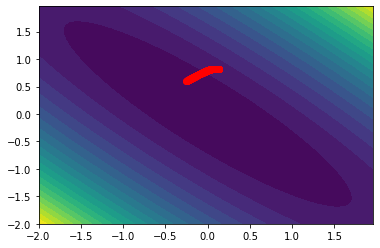

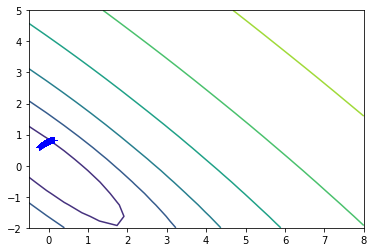

In [33]:
lw, _, _ = descente_gradient(datax, datay, mse, mse_grad, 1e-3, 1000)

lw = np.array(lw)
lw = lw.reshape(lw.shape[0], lw.shape[1])

plt.figure()
plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
plt.scatter(lw[:,0], lw[:,1],c='r')

plot_parametres(lw, datax, datay)

In [35]:
lw_tab = []
ll_tab = []
w_tab = []
n_epochs=200

lrs = np.logspace(-5,-1,5)
for lr in lrs:
    lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, lr, n_epochs)
    lw_tab.append(lw)
    ll_tab.append(ll)
    w_tab.append(w)

100%|██████████| 200/200 [00:00<00:00, 2481.35it/s]


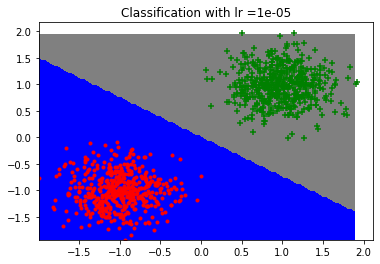

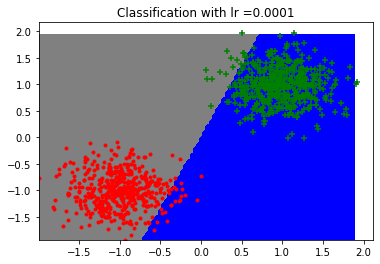

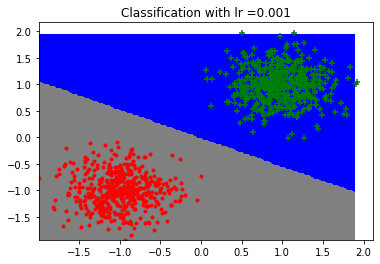

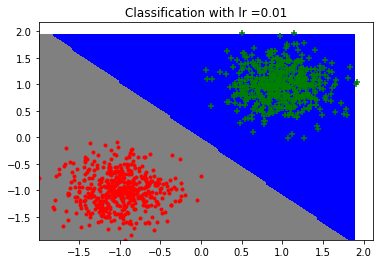

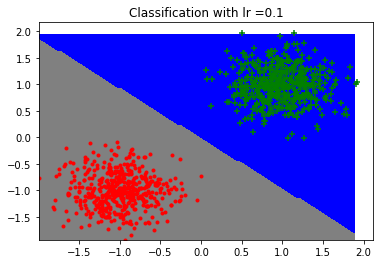

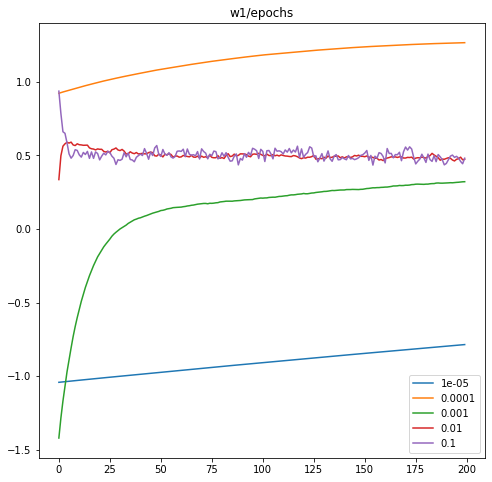

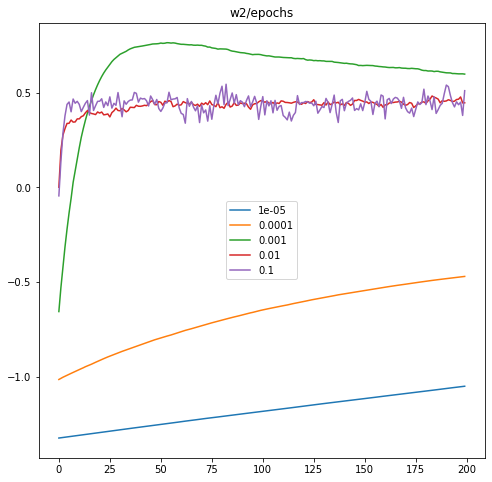

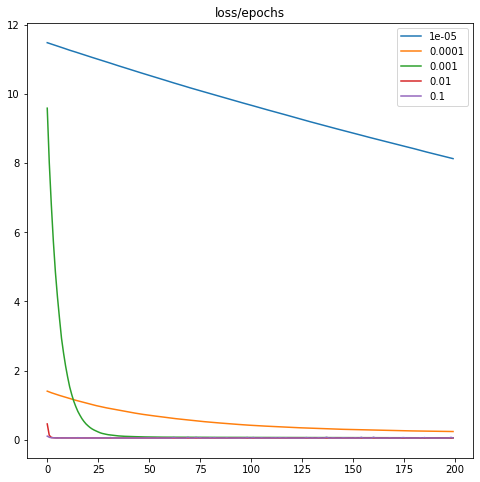

In [36]:
lr_analysis(lw_tab, ll_tab, w_tab, lrs)

- lr=1e-5 : learning rate too low, takes too much time to converge
- lr=1e-4 : ok classification
- lr=1e-3 : best classification
- lr=1e-2 : ok classification, seems to be diverging around optimal solution
- lr=1e-1 : ok classification, seems to be diverging a lot around optimal solution

#### Non linéarement séparable

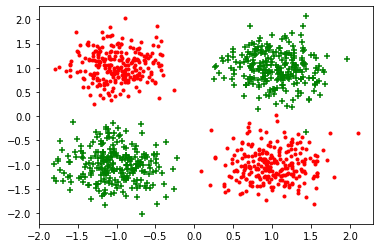

In [37]:
datax, datay = gen_arti(epsilon=0.1, data_type=1)
grid, x_grid, y_grid = make_grid(xmin=-2, xmax=2, ymin=-2, ymax=2, step=100)
plt.figure()
plot_data(datax,datay)

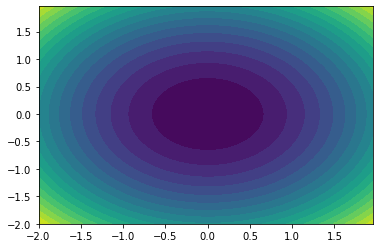

In [39]:
plt.figure()
plt.contourf(x_grid,y_grid,np.array([mse(w,datax,datay).mean() for w in grid]).reshape(x_grid.shape),levels=20)
plt.show()

100%|██████████| 500/500 [00:00<00:00, 2499.00it/s]


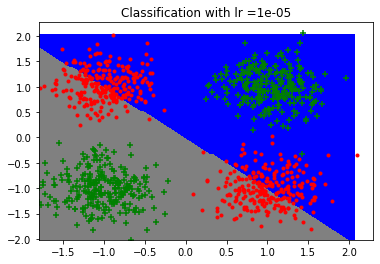

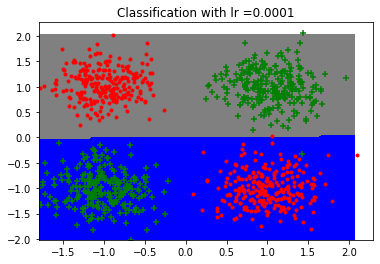

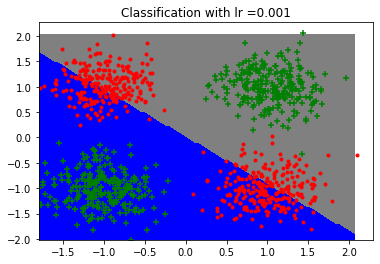

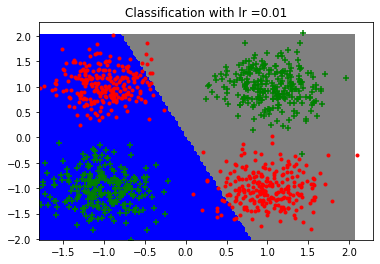

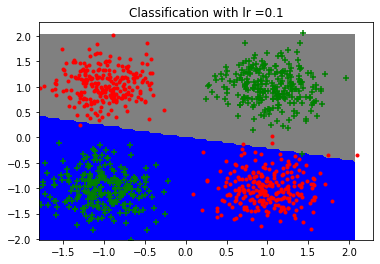

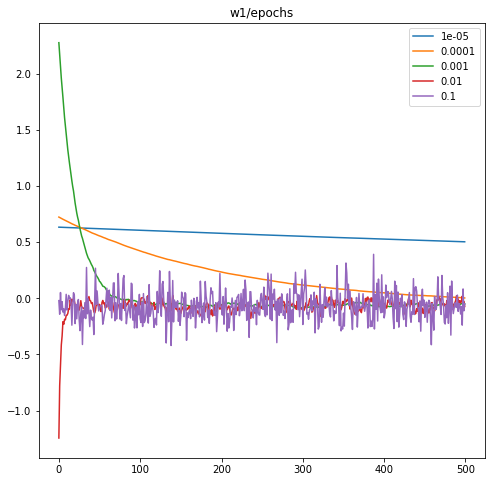

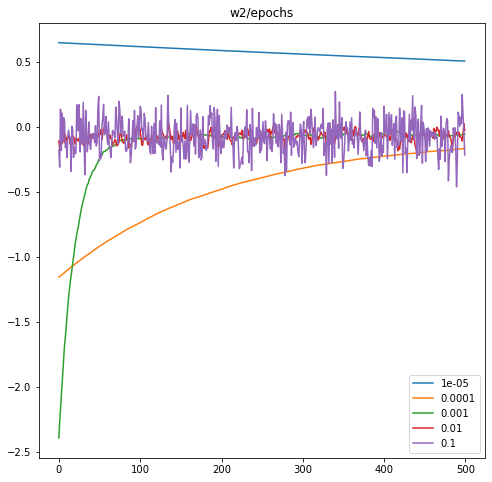

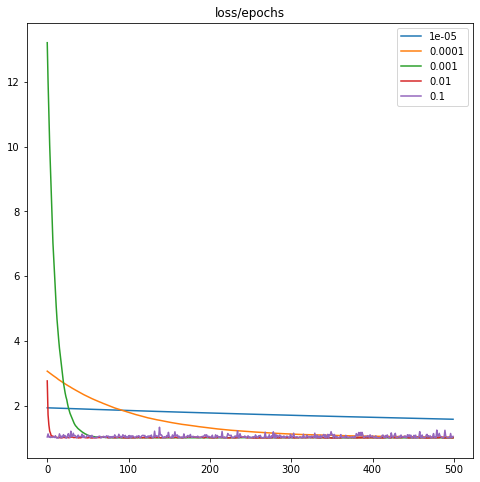

In [40]:
n_epochs = 500
lw_tab = []
ll_tab = []
w_tab = []

lrs = np.logspace(-5,-1,5)
for learning_rate in lrs:
    lw, ll, w = descente_gradient_minibatch(datax, datay, mse, mse_grad, learning_rate, n_epochs)
    lw_tab.append(lw)
    ll_tab.append(ll)
    w_tab.append(w)
lr_analysis(lw_tab, ll_tab, w_tab, lrs)

Tous LR donnent la mauvaise classif (évidemment)

# TME 4 - Perceptron

### Perceptron et classe Linéaire

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

def mse(w, x, y):
	return (x@w - y)**2

def mse_grad(w, x, y):
	return 2 * x * (x@w - y)

def reglog(w, x, y):
	return np.log(1 + np.exp(-y * (x@w)))

def reglog_grad(w, x, y):
	return -x * y / (1 + np.exp(y * (x @ w)))

def perceptron_loss(w, x, y):
	return np.maximum(0, -y * (x@w))

def perceptron_grad(w, x, y):
	return -y * x * (perceptron_loss(w, x, y) > 0)

In [2]:
class Lineaire(object):
	def __init__(self, loss=perceptron_loss, loss_g=perceptron_grad, max_iter=100, eps=0.01):
		self.max_iter, self.eps = max_iter,eps
		self.w = None
		self.loss, self.loss_g = loss, loss_g
		
	def fit(self, datax, datay):
		self.w = np.random.randn(datax.shape[1], 1)
		all_w = np.zeros((self.max_iter, datax.shape[1]))
		all_loss = np.zeros(self.max_iter)
		for i in range(self.max_iter):
			self.w = self.w - self.eps * np.mean(self.loss_g(self.w,datax,datay), axis=0).reshape(-1, 1)
			all_w[i] = self.w.T
			all_loss[i] = np.mean(self.loss(self.w, datax, datay))
		return self.w, all_w, all_loss

	def predict(self,datax):
		return np.sign(datax @ self.w)

	def score(self,datax,datay):
		return np.mean(self.predict(datax) == datay)

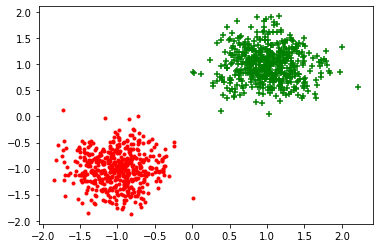

In [3]:
datax, datay = gen_arti(epsilon=0.1, data_type=0)
plt.figure()
plot_data(datax,datay)

Score: 0.926


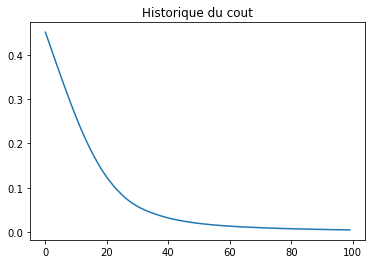

In [4]:
# Essayer le modele Lineaire avec les donnees artificielle puis tester sur l'ensemble d'apprentissage
model = Lineaire()
best_w, w_tab, loss_tab = model.fit(datax, datay)
print("Score:", model.score(datax, datay))
plt.plot(loss_tab)
plt.title("Historique du cout")
plt.show()

### Données USPS

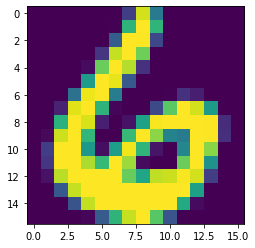

In [5]:
def load_usps(fn):
	with open(fn,"r") as f:
		f.readline()
		data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
	tmp=np.array(data)
	return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
	if type(l)!=list:
		resx = datax[datay==l,:]
		resy = datay[datay==l]
		return resx,resy
	tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
	tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
	return tmpx,tmpy

def show_usps(data):
	plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="viridis")

alltrainx,alltrainy = load_usps("data/USPS_train.txt")
alltestx,alltesty = load_usps("data/USPS_test.txt")

show_usps(alltrainx[0])

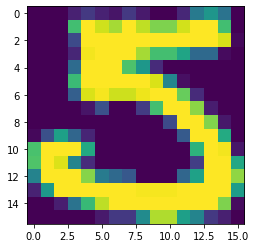

In [6]:
def get_two_classes(neg, pos):
	datax, datay = get_usps([neg,pos], alltrainx, alltrainy)
	testx, testy = get_usps([neg,pos], alltestx, alltesty)
	datay = np.where(datay == neg, -1, 1).reshape(-1, 1)
	testy = np.where(testy == neg, -1, 1).reshape(-1, 1)
	return datax, datay, testx, testy

datax, datay, testx, testy = get_two_classes(5, 6)
show_usps(datax[0])

In [7]:
def learn_1_vs_1(class_neg, class_pos, ModelType=Lineaire):
	datax, datay, testx, testy = get_two_classes(class_neg, class_pos)
	model = ModelType(max_iter=500)
	_, _, loss_tab = model.fit(datax, datay)
	print("Score:", model.score(testx, testy))
	plt.plot(loss_tab)
	plt.title(f"Historique du cout {class_neg} vs {class_pos}")
	plt.show()

Score: 0.8878787878787879


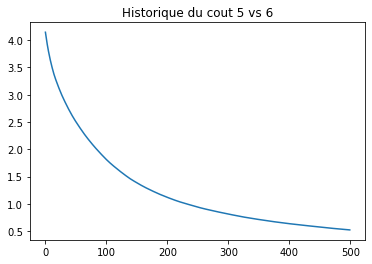

Score: 0.858433734939759


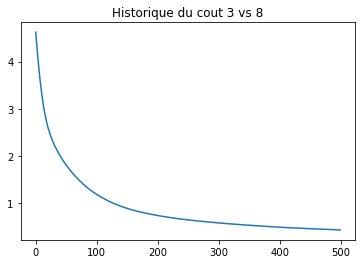

Score: 0.9567723342939481


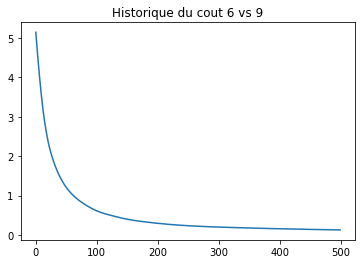

In [8]:
# Essayer le modele Lineaire avec les donnees USPS de deux classes, avec deux ensembles train et test differents
learn_1_vs_1(5,6)
learn_1_vs_1(3,8)
learn_1_vs_1(6,9)

In [9]:
def get_one_class(c):
	datay = np.where(alltrainy == c, 1, -1).reshape(-1, 1)
	testy = np.where(alltesty == c, 1, -1).reshape(-1, 1)
	return alltrainx, datay, alltestx, testy

def learn_1_vs_all(c, ModelType=Lineaire):
	datax, datay, testx, testy = get_one_class(c)
	model = ModelType(max_iter=500)
	_, _, loss_tab = model.fit(datax, datay)
	print("Score:", model.score(testx, testy))
	plt.plot(loss_tab)
	plt.title(f"Historique du cout {c} vs all")
	plt.show()

Score: 0.9476831091180867


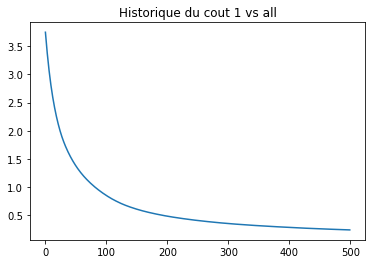

In [10]:
learn_1_vs_all(1)

Score: 0.8849028400597907


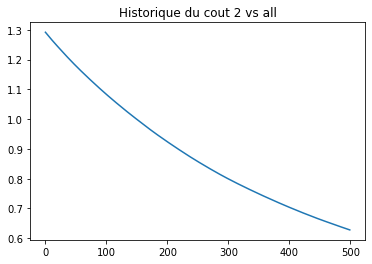

Score: 0.8824115595416044


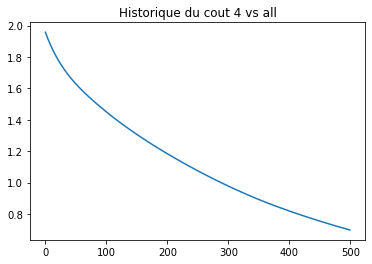

Score: 0.8704534130543099


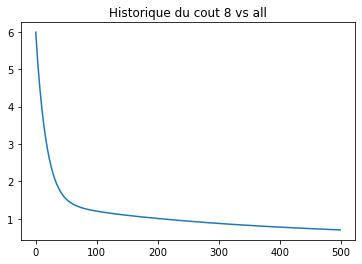

In [11]:
learn_1_vs_all(2)
learn_1_vs_all(4)
learn_1_vs_all(8)

### Mini-batch et descente stochastique

Score: 0.9606060606060606


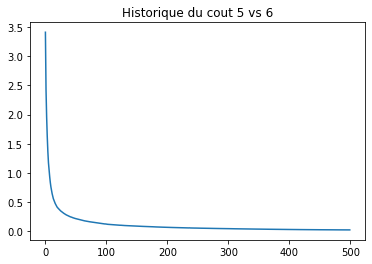

Score: 0.9307228915662651


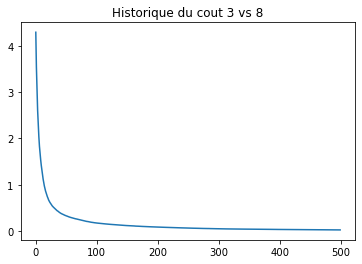

Score: 0.9855907780979827


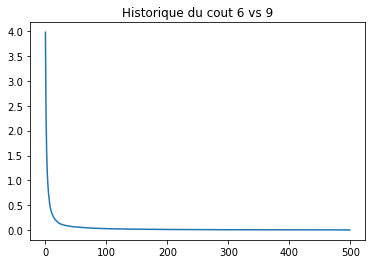

In [12]:
class MiniBatch(Lineaire):
	def __init__(self, loss=perceptron_loss, loss_g=perceptron_grad, max_iter=100, eps=0.01):
		super().__init__(loss, loss_g, max_iter, eps)
	
	def fit(self, datax, datay, n_batch=20):
		self.w = np.random.randn(datax.shape[1], 1)
		all_w = np.zeros((self.max_iter, datax.shape[1]))
		all_loss = np.zeros(self.max_iter)
		batch_size = datax.shape[0] // n_batch
		
		for i in range(self.max_iter):
			for _ in range(n_batch):
				batch_idx = np.random.choice(datax.shape[0], size=batch_size)
				x, y = datax[batch_idx], datay[batch_idx]
				self.w -= self.eps * np.mean(self.loss_g(self.w, x, y), axis=0).reshape(-1, 1)
			all_w[i] = self.w.T
			all_loss[i] = np.mean(self.loss(self.w, datax, datay))
		return self.w, all_w, all_loss

learn_1_vs_1(5,6, MiniBatch)
learn_1_vs_1(3,8, MiniBatch)
learn_1_vs_1(6,9, MiniBatch)

Score: 0.9666666666666667


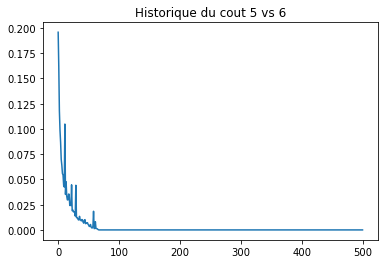

Score: 0.963855421686747


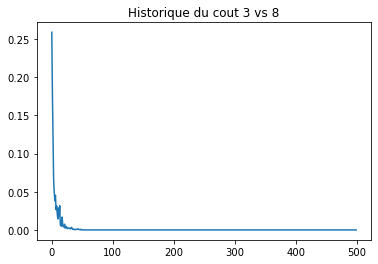

Score: 0.9855907780979827


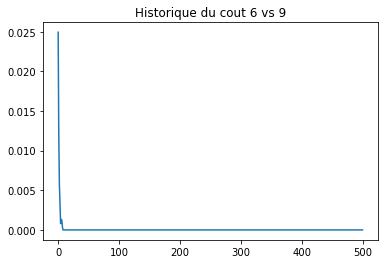

In [13]:
class Stoch(Lineaire):
	def __init__(self, loss=perceptron_loss, loss_g=perceptron_grad, max_iter=100, eps=0.01):
		super().__init__(loss, loss_g, max_iter, eps)
	
	def fit(self, datax, datay):
		self.w = np.random.randn(datax.shape[1], 1)
		all_w = np.zeros((self.max_iter, datax.shape[1]))
		all_loss = np.zeros(self.max_iter)
		all_idx = np.arange(datax.shape[0])
		
		for i in range(self.max_iter):
			np.random.shuffle(all_idx)
			for j in all_idx:
				x, y = datax[j], datay[j]
				if y * (self.w.reshape(-1) @ x) < 0:
					self.w += self.eps * y * x.reshape(-1, 1)
			all_w[i] = self.w.T
			all_loss[i] = np.mean(self.loss(self.w, datax, datay))
		return self.w, all_w, all_loss

learn_1_vs_1(5,6, Stoch)
learn_1_vs_1(3,8, Stoch)
learn_1_vs_1(6,9, Stoch)

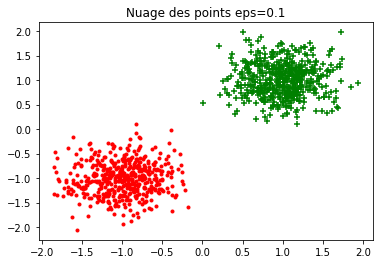

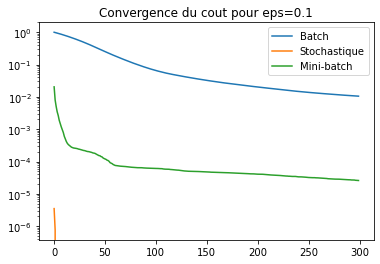

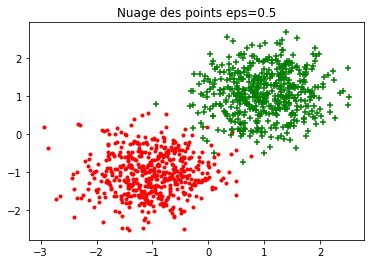

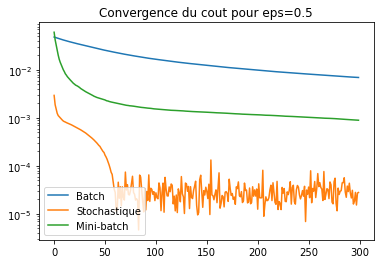

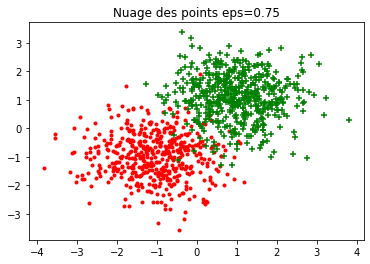

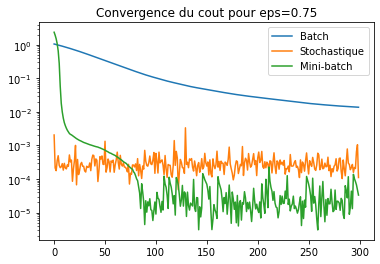

In [14]:
# On fait la comparaison entre les 3 methodes en fonction du bruit du jeu de données

n_iter = 300

for eps in (0.1, 0.5, 0.75):
	datax, datay = gen_arti(epsilon=eps, data_type=0)
	plot_data(datax, datay)
	plt.title(f"Nuage des points eps={eps}")
	plt.show()
	
	batch = Lineaire(max_iter=n_iter)
	stoch = Stoch(max_iter=n_iter)
	mini_b= MiniBatch(max_iter=n_iter)

	plt.plot(batch.fit(datax, datay)[2], label='Batch')
	plt.plot(stoch.fit(datax, datay)[2], label='Stochastique')
	plt.plot(mini_b.fit(datax, datay)[2], label='Mini-batch')
	plt.yscale('log')
	plt.legend()
	plt.title(f"Convergence du cout pour eps={eps}")
	plt.show()

On constate que pour les données clairement séparable, la descente stochastique et mini-batch trouve la classif parfaite très rapidement, voire instantamment. Pour les données plus bruitées, la descente stochastique montre la performance supérieure par rapport des autres

### Projections et pénalisation

In [15]:
from itertools import combinations

def proj_biais(datax):
	return np.hstack((np.ones((datax.shape[0], 1)), datax))

def proj_poly(datax):
	d = datax.shape[1]
	combi = np.zeros((datax.shape[0], d * (d-1) // 2))
	for i, (j, k) in enumerate(combinations(range(d), 2)):
		combi[:,i] = datax[:,j] * datax[:,k]
	return np.hstack((proj_biais(datax), combi, datax ** 2))

In [16]:
class Projection(object):
	def __init__(self, proj=proj_poly, ModelType=Lineaire, **kwargs):
		self.proj = proj
		self.model = ModelType(**kwargs)
		
	def fit(self, datax, datay):
		self.w, self.all_w, self.all_loss = self.model.fit(self.proj(datax), datay)
		return self.w, self.all_w, self.all_loss

	def predict(self, datax):
		return self.model.predict(self.proj(datax))

	def score(self, datax, datay):
		return self.model.score(self.proj(datax), datay)

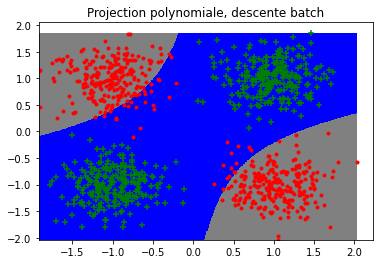

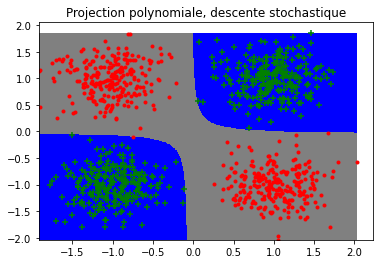

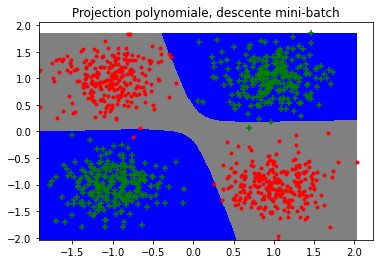

In [17]:
datax, datay = gen_arti(data_type=1)

proj = Projection(ModelType=Lineaire, max_iter=500)
proj.fit(datax, datay)
plot_frontiere(datax, lambda x: proj.predict(x),step=300)
plot_data(datax, datay)
plt.title("Projection polynomiale, descente batch")
plt.show()

proj = Projection(ModelType=Stoch, max_iter=200)
proj.fit(datax, datay)
plot_frontiere(datax, lambda x: proj.predict(x),step=300)
plot_data(datax, datay)
plt.title("Projection polynomiale, descente stochastique")
plt.show()

proj = Projection(ModelType=MiniBatch, max_iter=400)
proj.fit(datax, datay)
plot_frontiere(datax, lambda x: proj.predict(x),step=300)
plot_data(datax, datay)
plt.title("Projection polynomiale, descente mini-batch")
plt.show()

# TME 5 - SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

import warnings
warnings.filterwarnings("ignore")

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

In [2]:
def plot_learning_curve(
	estimator,
	title,
	X,
	y,
	axes=None,
	ylim=None,
	cv=None,
	n_jobs=None,
	train_sizes=np.linspace(0.1, 1.0, 5),
):
	if axes is None:
		_, axes = plt.subplots(1, 3, figsize=(20, 5))

	axes[0].set_title(title)
	if ylim is not None:
		axes[0].set_ylim(*ylim)
	axes[0].set_xlabel("Training examples")
	axes[0].set_ylabel("Score")

	train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
		estimator,
		X,
		y,
		cv=cv,
		n_jobs=n_jobs,
		train_sizes=train_sizes,
		return_times=True,
	)
	train_scores_mean = np.mean(train_scores, axis=1)
	train_scores_std = np.std(train_scores, axis=1)
	test_scores_mean = np.mean(test_scores, axis=1)
	test_scores_std = np.std(test_scores, axis=1)
	fit_times_mean = np.mean(fit_times, axis=1)
	fit_times_std = np.std(fit_times, axis=1)

	# Plot learning curve
	axes[0].grid()
	axes[0].fill_between(
		train_sizes,
		train_scores_mean - train_scores_std,
		train_scores_mean + train_scores_std,
		alpha=0.1,
		color="r",
	)
	axes[0].fill_between(
		train_sizes,
		test_scores_mean - test_scores_std,
		test_scores_mean + test_scores_std,
		alpha=0.1,
		color="g",
	)
	axes[0].plot(
		train_sizes, train_scores_mean, "o-", color="r", label="Training score"
	)
	axes[0].plot(
		train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
	)
	axes[0].legend(loc="best")

	# Plot n_samples vs fit_times
	axes[1].grid()
	axes[1].plot(train_sizes, fit_times_mean, "o-")
	axes[1].fill_between(
		train_sizes,
		fit_times_mean - fit_times_std,
		fit_times_mean + fit_times_std,
		alpha=0.1,
	)
	axes[1].set_xlabel("Training examples")
	axes[1].set_ylabel("fit_times")
	axes[1].set_title("Scalability of the model")

	# Plot fit_time vs score
	fit_time_argsort = fit_times_mean.argsort()
	fit_time_sorted = fit_times_mean[fit_time_argsort]
	test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
	test_scores_std_sorted = test_scores_std[fit_time_argsort]
	axes[2].grid()
	axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
	axes[2].fill_between(
		fit_time_sorted,
		test_scores_mean_sorted - test_scores_std_sorted,
		test_scores_mean_sorted + test_scores_std_sorted,
		alpha=0.1,
	)
	axes[2].set_xlabel("fit_times")
	axes[2].set_ylabel("Score")
	axes[2].set_title("Performance of the model")

	return plt

### SVM et GridSearch

In [5]:
def plot_frontiere_proba(data, f, step=20):
	grid, x, y = make_grid(data=data, step=step)
	plt.contourf(x, y, f(grid).reshape(x.shape), 255)
	
def plot_all(x, y, model):
	plt.figure()
	plot_frontiere_proba(x, lambda x: model.predict_proba(x)[:,0], step=50)
	plot_data(x,y)
	plt.show()
	
def test_and_plot_svm():
	kernels = ["linear", "rbf", "sigmoid", "poly"]
	data_types = [1,2]
	data_eps = [0.1]
	
	datax_tab = []
	datay_tab = []
	string_type = []
	string_eps = []
	for epsilon in data_eps:
		for data_type in data_types:
			datax, datay = gen_arti(nbex=3000, epsilon=epsilon, data_type=data_type)
			datay = datay.reshape(-1)
			datax_tab.append(datax)
			datay_tab.append(datay)
			string_type.append(data_type)
			string_eps.append(epsilon)
			
	# generation de tout les types de svm
	for i in range(len(datax_tab)):
		X_train, X_test, Y_train, Y_test = train_test_split(datax_tab[i], datay_tab[i], test_size=0.2, shuffle=True)
		max_score = 0
		for ker in kernels:
			print("KERNEL:", ker, "DATA TYPE:", string_type[i], "DATA_EPSILON:", string_eps[i])
			parameters = {
				'C': np.logspace(-3, 2, 6),
				"gamma" : np.logspace(-3, 2, 6)
			}
			svm = GridSearchCV(SVC(max_iter=500,
									probability=True,
									kernel=ker),
								parameters, 
								scoring="accuracy",
								n_jobs=8, 
								cv=3,
								refit=True
								)
			svm.fit(X_train, Y_train)
			pred = svm.predict(X_test)
			acc = accuracy_score(pred, Y_test)
			print("ACCURACY:", acc)
			if acc > max_score:
				max_score = acc
				best_i = i
				best_svm = svm
				best_model_name = ker
			
		print("BEST MODEL:", best_model_name, "BEST C:", best_svm.best_params_)
		plot_all(datax_tab[best_i], datay_tab[best_i], best_svm) 
		plt.show()

KERNEL: linear DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.5016666666666667
KERNEL: rbf DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.995
KERNEL: sigmoid DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.575
KERNEL: poly DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.5016666666666667
BEST MODEL: rbf BEST C: {'C': 0.001, 'gamma': 1.0}


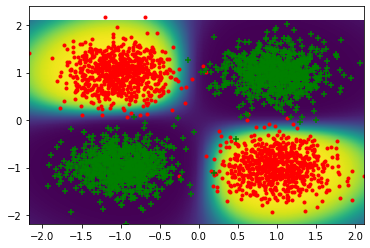

KERNEL: linear DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.4766666666666667
KERNEL: rbf DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.8183333333333334
KERNEL: sigmoid DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.495
KERNEL: poly DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.515
BEST MODEL: rbf BEST C: {'C': 1.0, 'gamma': 10.0}


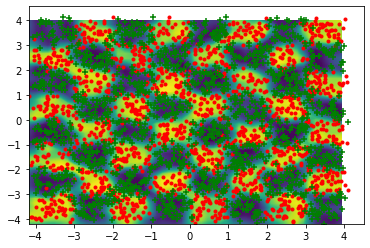

In [6]:
test_and_plot_svm()

### Apprentissage multi-classe

In [8]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="viridis")

def get_two_classes(neg, pos):
	datax, datay = get_usps([neg,pos], alltrainx, alltrainy)
	testx, testy = get_usps([neg,pos], alltestx, alltesty)
	datay = np.where(datay == neg, -1, 1).reshape(-1, 1)
	testy = np.where(testy == neg, -1, 1).reshape(-1, 1)
	return datax, datay, testx, testy

def get_one_class(c):
	datay = np.where(alltrainy == c, 1, -1).reshape(-1, 1)
	testy = np.where(alltesty == c, 1, -1).reshape(-1, 1)
	return alltrainx, datay, alltestx, testy

alltrainx,alltrainy = load_usps("data/USPS_train.txt")
alltestx,alltesty = load_usps("data/USPS_test.txt")